In [1]:
import sys
sys.path.append('../src')

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import numpy as np
from glob import glob
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import Markdown

from geoq import geom
world = geom.get_world()

## read all image embeddings

In [2]:
files = glob('/datasets/genai-geo-embeddings/chips/*.pkl')
def readf(fname):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
        
    return {k: z[k] for k in ['chip_id', 'image_embedding', 'lonlat']}

embs = Parallel(verbose=5, n_jobs=-1)(delayed(readf)(fname) for fname in files)
embs = pd.DataFrame(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 782 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4704 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8360 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 15392 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 23168 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 31520 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 40448 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 44837 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 45512 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 46178 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 46880 ta

## create an array with all vectors for searching

In [3]:
vdb = np.r_[[np.r_[i] for i in embs.image_embedding.values]]
vdb.shape

(48313, 1024)

In [4]:
embs.head()

,chip_id,image_embedding,lonlat
0,095cfcd323303,"[-0.15446948139630945, -0.8008331826464329, 0....","(91.34310709799735, 50.41987022773517)"
1,1de2ec148d69e,"[0.8415447773467286, -1.014063691213066, 0.575...","(-64.27066308931353, -31.05902171821698)"
2,0390ba50042b7,"[-0.41698809152843436, -0.8745452401816721, -0...","(88.88300854819661, 33.096023502661836)"
3,006c8f2f97054,"[-0.6805527541385149, -0.03299440372034366, 0....","(-69.98211629173304, -28.85582200279133)"
4,133a7a94508ae,"[2.4108663746214565, -0.9381802851194865, 1.23...","(76.68477394326017, 10.599668934745567)"


## select a random image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

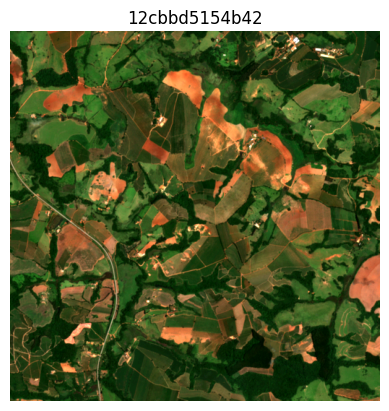

In [14]:
file = np.random.choice(files)
with open(file, 'rb') as f:
    z = pickle.load(f)
plt.imshow(z['img'])
plt.title(z['chip_id'])
plt.axis('off')


## get the top N most similar

In [15]:
n = 10

distances = np.sum((vdb - z['image_embedding'])**2, axis=1)
topn_idxs = np.argsort(distances)[:n]

In [16]:
topn = embs.iloc[topn_idxs].copy()
topn['distance'] = distances[topn_idxs]
topn

,chip_id,image_embedding,lonlat,distance
29361,12cbbd5154b42,"[0.32681571077620253, -1.0203659141594685, 1.1...","(-45.505807564634836, -21.19845466528561)",0.000000
43783,3652c46171d6a,"[0.0684323947948799, -1.038170151011457, 0.869...","(-46.04516186311993, -20.733409669403898)",153.299567
1275,1c95b00eead4e,"[-0.22394143676258987, -0.9599449048950391, 0....","(-45.83702807248185, -19.976218910714433)",158.746622
15736,1519ce0210e55,"[-0.5987349035493921, -1.0198074122058376, 0.9...","(-45.99508779092447, -20.594929458392013)",160.566472
8508,137895c74f0f5,"[0.050628466879399904, -0.7576694333443947, 0....","(-49.72282436598079, -17.330989690017834)",166.450663
8688,1af186ea42036,"[-0.09556916809387961, -1.0013178976958483, 1....","(-45.111847697361995, -22.078094616833937)",175.123837
30200,0cb4f34b18264,"[0.8139969254531854, -1.122827442634656, 1.370...","(-45.80201668149195, -21.2435662022935)",176.513799
39343,32d698605e1f3,"[0.04036934217762501, -0.6848967347638985, 0.8...","(26.52015023501818, 55.06150344432558)",180.363504
2067,078e67933901b,"[-0.5348785983279264, -0.40043205742926163, 1....","(9.361638637152772, 50.41817796577192)",186.314274
41692,00e406bb7e68d,"[0.26314188348628065, -0.5750188938190551, 0.4...","(-46.092025660799564, -20.409309340658655)",192.685008


In [17]:
# the most similar one must be the query chip itself

assert topn.chip_id.values[0] == z['chip_id']

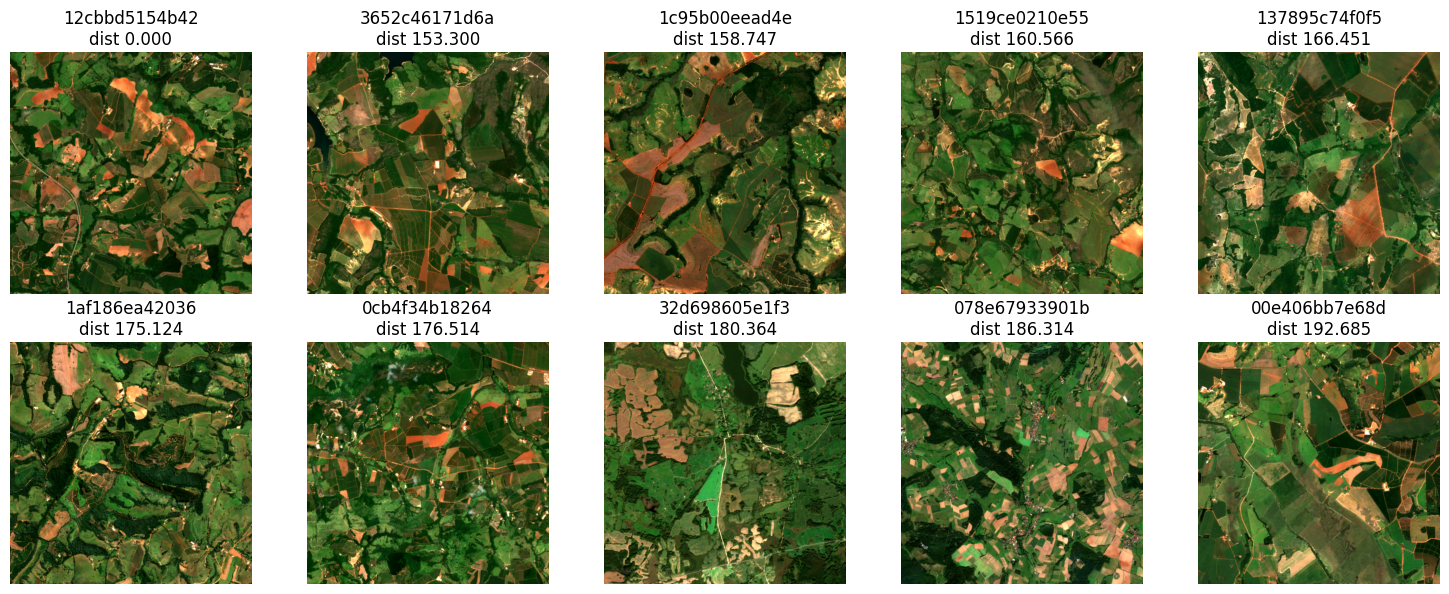

In [20]:
fig = plt.figure(figsize=(15,6))
axs = fig.subplots(2,5).flatten()

for i, (_, ti) in enumerate(topn.iterrows()):
    file = files[ti.name]
    ax = axs[i]

    # sanity check, chip id must be the same as file if
    assert file.split('/')[-1].split('.')[0] == ti.chip_id

    with open(file, 'rb') as f:
        z = pickle.load(f)    

    ax.imshow(z['img'])
    ax.set_axis_off()

    ax.set_title(f'{ti.chip_id}\ndist {ti.distance:0.3f}')
    
fig.tight_layout()

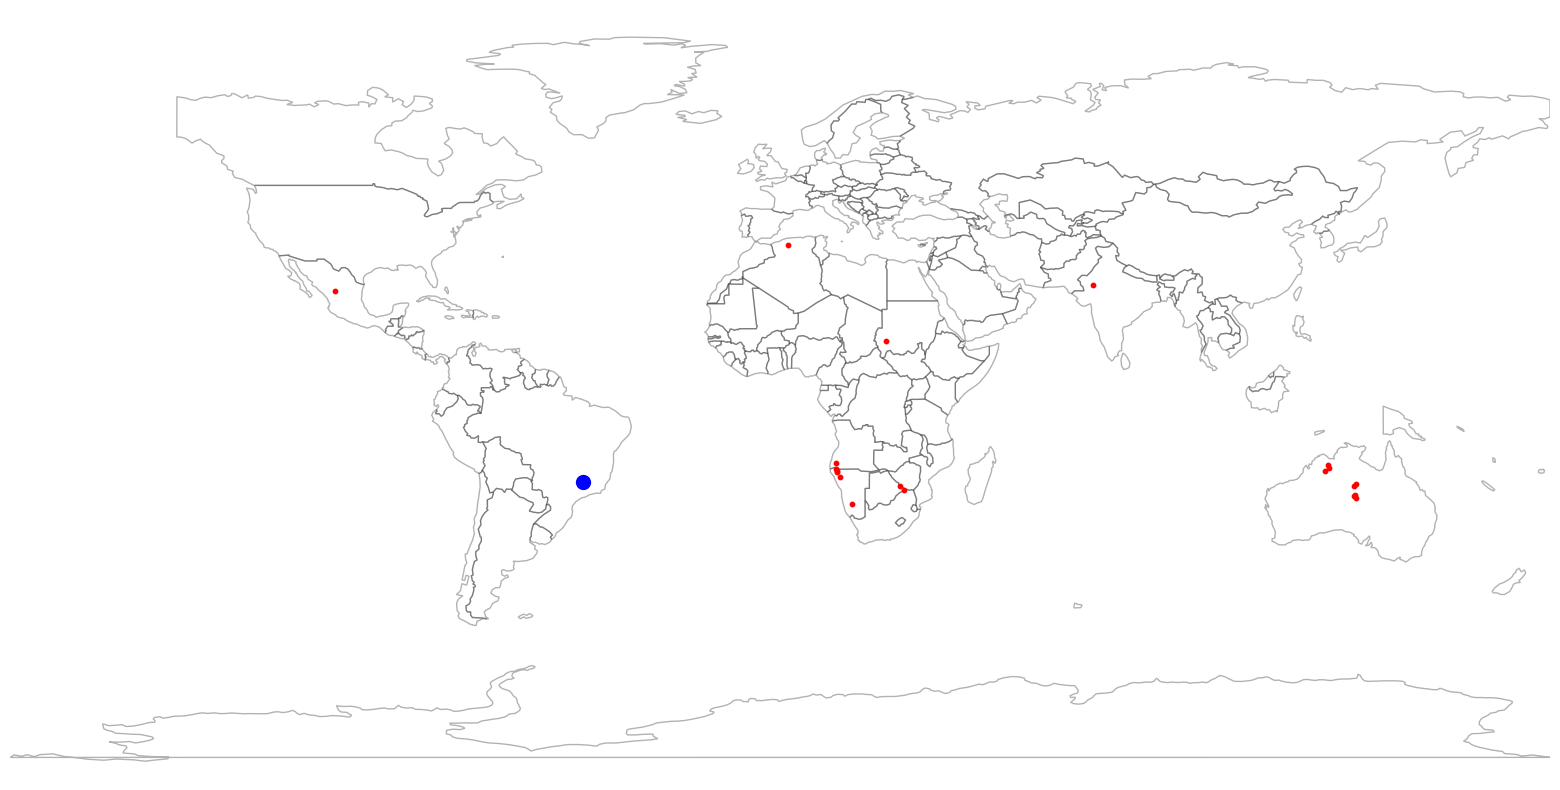

In [21]:
# query point in blue

lonlats = np.r_[[np.r_[i] for i in top20.lonlat.values]]

ax = plt.figure(figsize=(20,10)).subplots(1,1)
gplt.polyplot(world, alpha=0.3,  ax=ax)
plt.scatter(lonlats[:,0], lonlats[:,1], color='red', alpha=1, s=10)
plt.scatter(*z['lonlat'], color='blue', s=100)